In [1]:
import tensorflow as tf
import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

In [2]:
# timer code
    # import time
    # tic = time.perf_counter()                                     add this in the beginning of the CNN
    # toc = time.perf_counter()                                     add this at the end of the code
    # print (f"Finished running in {toc - tic: 0.2f} seconds")      add after the toc command

In [3]:
print  ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print(tf.config.list_physical_devices)

<function list_physical_devices at 0x7f1067dc90e0>


In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5381937959196892256
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1026168901241116526
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
test = pd.read_csv("drive/MyDrive/updated_news.csv", names = ["rating", "title"])


test.head()

,rating,title
0,0,The lie that coronavirus came from a bat or a ...
1,0,The health experts had predicted the virus cou...
2,0,The Centers for Disease Control and Prevention...
3,2,Warm weather will kill coronavirus. U.S. Presi...
4,0,Using a hair dryer to breathe in hot air can c...


In [8]:
test['rating'].value_counts()

0    3041
1     659
2     429
Name: rating, dtype: int64

In [9]:
# conv1d kernel size = 128 x 5 
# LSTM kernel size = 32

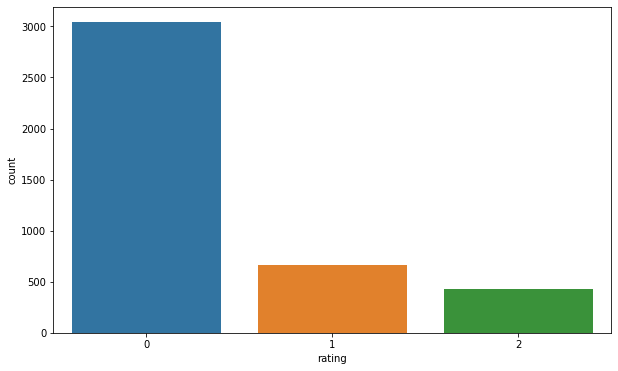

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=test)

In [11]:
test['title'] = test['title'].apply(lambda x: str(x).lower())

In [12]:
test = test[['title', 'rating']]

In [13]:
test['rating'] = test['rating'].astype(float)

In [14]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 10.4 MB 3.5 MB/s 
     |████████████████████████████████| 2.2 MB 39.6 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 534 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 4.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-075qdfsx
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip

In [15]:
import preprocess_kgptalkie as ps

In [16]:
test['title'] = test['title'].apply(lambda x: ps.remove_special_chars(x))

In [17]:
ps.remove_special_chars('this ,. @ is gre@t')

'this is gret'

In [18]:
test.head()

,title,rating
0,the lie that coronavirus came from a bat or a ...,0.0
1,the health experts had predicted the virus cou...,0.0
2,the centers for disease control and prevention...,0.0
3,warm weather will kill coronavirus us presiden...,2.0
4,using a hair dryer to breathe in hot air can c...,0.0


In [19]:
x = [d.split() for d in test['title'].tolist()]
y = test['rating'].values

In [20]:
pip install imbalanced-learn

In [21]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
print(imblearn.__version__)

0.8.1


In [22]:
print(len(x))

4129


In [23]:
DIM = 300
w2v_model = gensim.models.Word2Vec(sentences=x, size=DIM, window=10, min_count=1)

In [24]:
len(w2v_model.wv.vocab)

9346

In [25]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x)

In [26]:
x = tokenizer.texts_to_sequences(x)

In [27]:
# tokenizer.word_index

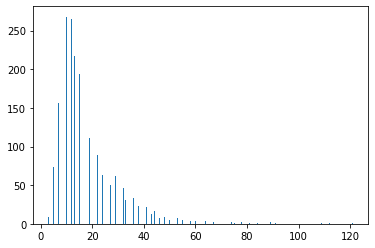

In [28]:
plt.hist([len(a) for a in x], bins = 700)
plt.show()

In [29]:
nos = np.array([len(a) for a in x])
len(nos[nos>1000])

0

In [30]:
maxlen = 100
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen)

In [31]:
len(x[101])

100

In [32]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [33]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [34]:
embedding_vectors = get_weight_matrix(w2v_model)

In [35]:
embedding_vectors.shape


(9347, 300)

In [36]:
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
#model.add(tf.keras.layers.LSTM(units=100))
#model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
model = Sequential()

model.add(Input(shape=100))
model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(512, 5, activation="relu", input_dim=96))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid"))
model.add(LSTM(128))
model.add(Dense(3, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          2804100   
                                                                 
 conv1d (Conv1D)             (None, 96, 512)           768512    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 512)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,901,191
Trainable params: 1,097,091
Non-trainable params: 2,804,100
______________________________________

In [38]:
X_train = x[0:3000]
X_test = y[0:3000]
y_train = x[3000:4129]
y_test = y[3000:4129]

In [39]:
X_test = [[1,0,0] if x==0.0 else [0,1,0] if x==1.0 else [0,0,1] if x==2.0 else x for x in X_test]
y_test = [[1,0,0] if x==0.0 else [0,1,0] if x==1.0 else [0,0,1] if x==2.0 else x for x in y_test]

In [40]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [41]:
oversample = RandomOverSampler(sampling_strategy='auto')
X_over, y_over = oversample.fit_resample(X_train, X_test)

In [42]:
fakecount = 0
truecount = 0
unverifiedcount = 0
print(len(X_over), len(y_over))
for value in y_over:
  if all(map(lambda x, y: x == y, value, [1,0,0])):
    fakecount += 1
  elif all(map(lambda x, y: x == y, value, [0,1,0])):
    truecount += 1
  elif all(map(lambda x, y: x == y, value, [0,0,1])):
    unverifiedcount += 1

print(fakecount,truecount,unverifiedcount)

6180 6180
2060 2060 2060


In [51]:
model.fit(X_over, y_over, epochs=200)

Epoch 1/200
194/194 [==============================] - 7s 38ms/step - loss: 8.7637e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 0.8772 - true_negatives: 11495.0000 - true_positives: 6180.0000 - false_positives: 865.0000 - false_negatives: 0.0000e+00
Epoch 2/200
194/194 [==============================] - 6s 32ms/step - loss: 8.0481e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 0.8798 - true_negatives: 11516.0000 - true_positives: 6180.0000 - false_positives: 844.0000 - false_negatives: 0.0000e+00
Epoch 3/200
194/194 [==============================] - 5s 25ms/step - loss: 7.2081e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 0.8816 - true_negatives: 11530.0000 - true_positives: 6180.0000 - false_positives: 830.0000 - false_negatives: 0.0000e+00
Epoch 4/200
194/194 [==============================] - 5s 26ms/step - loss: 6.6509e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 0.8851 - true_negatives: 11558.0000 - true_positives: 6180.0000 - false_positives: 802.000

In [52]:
model.evaluate(y_train, y_test)

36/36 [==============================] - 1s 16ms/step - loss: 1.8450 - accuracy: 0.7077 - recall: 0.8087 - precision: 0.6219 - true_negatives: 1703.0000 - true_positives: 913.0000 - false_positives: 555.0000 - false_negatives: 216.0000


[1.844982385635376,
 0.7077059149742126,
 0.8086802363395691,
 0.6219345927238464,
 1703.0,
 913.0,
 555.0,
 216.0]

In [45]:
y_predunsure = model.predict(y_train)

In [46]:
y_predsure = (model.predict(y_train) >= 0.5).astype(int)

In [47]:
for prediction in y_predunsure:
  highest = 0
  for value in prediction:
    if value > highest:
      highest = value

  predvalueindex = np.where(prediction == highest)
  prediction[predvalueindex] = int(1)
  for x in prediction:
    if x != 1:
      prediction[np.where(prediction == x)] = 0    

In [48]:
fake = 0
true = 0
unverified = 0
predtrueacfake = 0
predtrueacunverified = 0
predfakeactrue = 0
predfakeacunverified = 0
predunverifiedactrue = 0
predunverifiedacfake = 0

for x in range(len(y_predunsure)):
  result = all(map(lambda x, y: x == y, y_predunsure[x], y_test[x]))
  if result == True:
    if all(map(lambda x, y: x == y, y_predunsure[x], [1,0,0])):
      fake+=1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [0,1,0])):
      true += 1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [0,0,1])):
      unverified+=1
  elif result == False:
    if all(map(lambda x, y: x == y, y_predunsure[x], [0,1,0])) and all(map(lambda x, y: x == y, y_test[x], [1,0,0])):
      predtrueacfake += 1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [0,1,0])) and all(map(lambda x, y: x == y, y_test[x], [0,0,1])):
      predtrueacunverified += 1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [1,0,0])) and all(map(lambda x, y: x == y, y_test[x], [0,1,0])):
      predfakeactrue += 1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [1,0,0])) and all(map(lambda x, y: x == y, y_test[x], [0,0,1])):
      predfakeacunverified += 1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [0,0,1])) and all(map(lambda x, y: x == y, y_test[x], [0,1,0])):
      predunverifiedactrue += 1
    elif all(map(lambda x, y: x == y, y_predunsure[x], [0,0,1])) and all(map(lambda x, y: x == y, y_test[x], [1,0,0])):
      predunverifiedacfake += 1

print(fake, true, unverified, predtrueacfake, predtrueacunverified, predfakeactrue, predfakeacunverified, predunverifiedactrue, predunverifiedacfake)


773 17 11 148 24 42 50 4 60


In [49]:
fake = 0
true = 0
unverified = 0
predtrueacfake = 0
predtrueacunverified = 0
predfakeactrue = 0
predfakeacunverified = 0
predunverifiedactrue = 0
predunverifiedacfake = 0

for x in range(len(y_predsure)):
  result = all(map(lambda x, y: x == y, y_predsure[x], y_test[x]))
  if result == True:
    if all(map(lambda x, y: x == y, y_predsure[x], [1,0,0])):
      fake+=1
    elif all(map(lambda x, y: x == y, y_predsure[x], [0,1,0])):
      true += 1
    elif all(map(lambda x, y: x == y, y_predsure[x], [0,0,1])):
      unverified+=1
  elif result == False:
    if all(map(lambda x, y: x == y, y_predsure[x], [0,1,0])) and all(map(lambda x, y: x == y, y_test[x], [1,0,0])):
      predtrueacfake += 1
    elif all(map(lambda x, y: x == y, y_predsure[x], [0,1,0])) and all(map(lambda x, y: x == y, y_test[x], [0,0,1])):
      predtrueacunverified += 1
    elif all(map(lambda x, y: x == y, y_predsure[x], [1,0,0])) and all(map(lambda x, y: x == y, y_test[x], [0,1,0])):
      predfakeactrue += 1
    elif all(map(lambda x, y: x == y, y_predsure[x], [1,0,0])) and all(map(lambda x, y: x == y, y_test[x], [0,0,1])):
      predfakeacunverified += 1
    elif all(map(lambda x, y: x == y, y_predsure[x], [0,0,1])) and all(map(lambda x, y: x == y, y_test[x], [0,1,0])):
      predunverifiedactrue += 1
    elif all(map(lambda x, y: x == y, y_predsure[x], [0,0,1])) and all(map(lambda x, y: x == y, y_test[x], [1,0,0])):
      predunverifiedacfake += 1

print(fake, true, unverified, predtrueacfake, predtrueacunverified, predfakeactrue, predfakeacunverified, predunverifiedactrue, predunverifiedacfake)


618 10 2 61 10 30 39 2 24
